In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve
)
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import json


In [2]:
csv_path = "ER_FileUUID_FPKMofDEGs_Subtype.csv"
df = pd.read_csv(csv_path)

In [ ]:
# Drop identifier columns if present
df = df.drop(columns=[col for col in ['Patient ID', 'File_UUID'] if col in df.columns])

# Keep only samples with Positive/Negative labels and map to 1/0
df = df[df['er_status_by_ihc'].isin(['Positive', 'Negative'])].copy()
label_map = {'Positive': 1, 'Negative': 0}
df['er_status_by_ihc'] = df['er_status_by_ihc'].map(label_map)


# Split X and y, keep only numeric features
y = df['er_status_by_ihc']
X = df.drop(columns=['er_status_by_ihc'])
X = X.select_dtypes(include=[np.number]).copy()
X = X.fillna(X.mean())
feature_names = X.columns.tolist()

print("Samples:", X.shape[0], "Features:", X.shape[1])
print("Class distribution:\n", y.value_counts())

X_values = X.values
y_values = y.values

Samples: 498 Features: 2793
Class distribution:
 er_status_by_ihc
1    323
0    175
Name: count, dtype: int64


In [4]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_dist = {
    'xgb__n_estimators': [100, 200, 300, 500],
    'xgb__max_depth': [3, 5, 7, 10],
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__gamma': [0, 0.1, 0.3, 0.5],
    'xgb__reg_alpha': [0, 0.01, 0.1, 1],
    'xgb__reg_lambda': [1, 1.5, 2]
}

# Pipeline to ensure scaling is applied inside CV
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb_clf)
])


In [ ]:
# Outer CV (stratified)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Storage for fold results
fold_results = []
mean_fpr = np.linspace(0, 1, 100)  # for mean ROC curve interpolation
tprs = []

#  Outer CV loop with inner RandomizedSearchCV 
fold_idx = 0
for train_idx, test_idx in outer_cv.split(X_values, y_values):
    fold_idx += 1
    X_train, X_test = X_values[train_idx], X_values[test_idx]
    y_train, y_test = y_values[train_idx], y_values[test_idx]

    # inner randomized search to tune hyperparams using cv=3 on the training fold
    inner_search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist,
        n_iter=20,            # reduce or increase as needed
        scoring='roc_auc',
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    inner_search.fit(X_train, y_train)
    best = inner_search.best_estimator_

    # Predict on hold-out test fold
    y_pred = best.predict(X_test)
    if hasattr(best, "predict_proba"):
        y_proba = best.predict_proba(X_test)[:, 1]
    else:
        # fallback for models without predict_proba
        y_proba = best.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    # ROC details for plotting mean ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    # interpolate tpr at mean_fpr points
    from numpy import interp
    interp_tpr = interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

    fold_info = {
        'fold': fold_idx,
        'n_train': X_train.shape[0],
        'n_test': X_test.shape[0],
        'accuracy': acc,
        'roc_auc': roc_auc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'confusion_matrix': cm.tolist(),
        'best_params': inner_search.best_params_
    }
    fold_results.append(fold_info)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


D:\Miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:48:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


D:\Miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:50:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


D:\Miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:52:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


D:\Miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:55:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


D:\Miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:57:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
print(f"\n=== Fold {fold_idx} results ===")
print("Accuracy: %.4f   ROC AUC: %.4f   Precision: %.4f   Recall: %.4f   F1: %.4f" %
    (acc, roc_auc, prec, rec, f1))
print("Confusion matrix:\n", cm)
print("Best params (inner search):")
print(json.dumps(inner_search.best_params_, indent=2))

# Aggregate & report
results_df = pd.DataFrame(fold_results)
metrics = ['accuracy','roc_auc','precision','recall','f1']
agg = results_df[metrics].agg(['mean','std']).T
print("\n\n=== Aggregated metrics across 5 folds ===")
print(agg)


=== Fold 5 results ===
Accuracy: 0.9596   ROC AUC: 0.9808   Precision: 0.9545   Recall: 0.9844   F1: 0.9692
Confusion matrix:
 [[32  3]
 [ 1 63]]
Best params (inner search):
{
  "xgb__subsample": 1.0,
  "xgb__reg_lambda": 1.5,
  "xgb__reg_alpha": 0.1,
  "xgb__n_estimators": 500,
  "xgb__max_depth": 7,
  "xgb__learning_rate": 0.2,
  "xgb__gamma": 0,
  "xgb__colsample_bytree": 0.8
}


=== Aggregated metrics across 5 folds ===
               mean       std
accuracy   0.955859  0.008781
roc_auc    0.976802  0.011430
precision  0.963470  0.016272
recall     0.969087  0.015326
f1         0.966099  0.006639


C:\Users\Shruthi N K\AppData\Local\Temp\ipykernel_34740\2255430029.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mean_auc = np.trapz(mean_tpr, mean_fpr)  # approximate AUC from mean curve


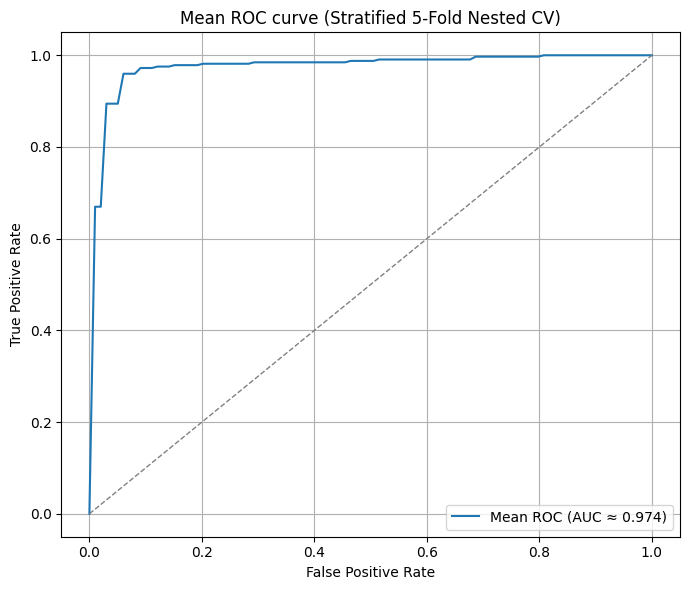


Best fold: 4 ROC AUC: 0.9941964285714286


In [11]:
# Save fold-level results
results_df.to_csv("nested_cv_fold_results.csv", index=False)
agg.to_csv("nested_cv_summary_metrics.csv")

# ---------- Plot mean ROC curve ----------
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.trapz(mean_tpr, mean_fpr)  # approximate AUC from mean curve

plt.figure(figsize=(7,6))
plt.plot(mean_fpr, mean_tpr, label=f"Mean ROC (AUC ≈ {mean_auc:.3f})")
plt.plot([0,1],[0,1], linestyle='--', color='gray', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Mean ROC curve (Stratified 5-Fold Nested CV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("mean_roc_nested_cv.png", dpi=150)
plt.show()

# ---------- Optional: train a final model on full data using best hyperparams (from best fold) and run SHAP ----------
# If you'd like to inspect SHAP across full data, you can pick the best params from the fold with highest roc_auc and fit:
best_fold = max(fold_results, key=lambda x: x['roc_auc'])
print("\nBest fold:", best_fold['fold'], "ROC AUC:", best_fold['roc_auc'])
best_params = best_fold['best_params']


D:\Miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:19:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


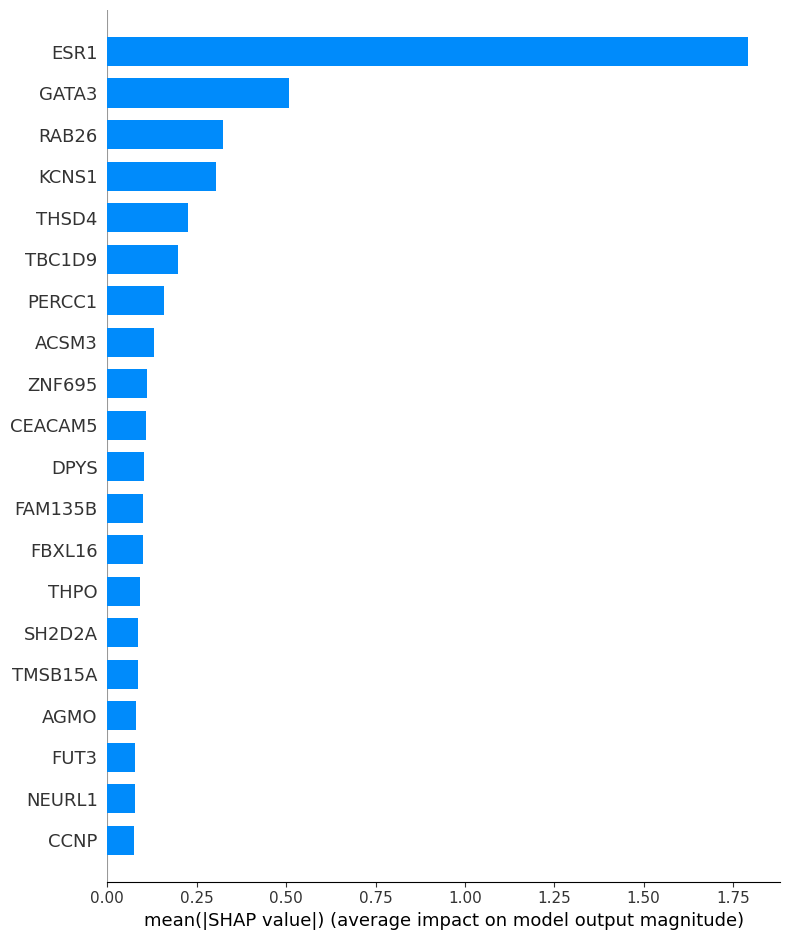

In [12]:
# Convert param keys from 'xgb__param' back to XGB param names if necessary
# Example: {'xgb__n_estimators': 200, ...}
xgb_params = {k.split('__')[1]: v for k,v in best_params.items()}

# Fit final model on whole dataset
final_pipe = Pipeline([('scaler', StandardScaler()),
                       ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, **xgb_params))])
final_pipe.fit(X_values, y_values)

# If you want SHAP summary plot (requires shap):
try:
    import shap
    explainer = shap.TreeExplainer(final_pipe.named_steps['xgb'])
    # Note: use scaled features (pipeline scaler) or original features? We'll use scaled
    X_scaled_full = final_pipe.named_steps['scaler'].transform(X_values)
    shap_values = explainer.shap_values(X_scaled_full)
    shap.summary_plot(shap_values, X_scaled_full, feature_names=feature_names, plot_type="bar", max_display=20)
except Exception as e:
    print("Could not run SHAP (shap might not be installed). Error:", e)